# Analysis Demo

In [1]:
# Disable warnings for prettier notebook
import warnings
warnings.filterwarnings("ignore")

In [6]:
from pathlib import Path
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import squidpy as sq

In [3]:
from popari import pl, tl
from popari.model import load_trained_model

## Load trained model

In [7]:
data_directory = Path("/work/magroup/shahula/spatiotemporal_transcriptomics_integration/data/STARmapPlus/SCP1375/")
demo = load_trained_model(data_directory / f"hierarchical_results.h5ad", verbose=0) # Replace with path to your trained model

```{note}
All data (including input gene expression data, spatial coordinates, learned embeddings/metagenes/spatial affinities) can be found within the `popari.model.Popari.datasets` attribute. You can build your own analysis functions that access these data; see `popari.analysis` and `popari._dataset_utils` for examples.
```

## Postprocessing

First, we Z-score normalize the Popari embeddings; this ensures that the dimensions of the latent space are weighted equally for downstream tasks such as clustering.  

In [8]:
tl.preprocess_embeddings(demo, normalized_key="normalized_X")

We can then cluster the embeddings to uncover cell types or other spatially-coherent groupings of the samples. The clustering can either be done separately for each FOVs (default), or jointly for all datasets (using `joint=True`).

In [9]:
tl.leiden(demo, joint=True, use_rep="normalized_X")

We can also compute the empirical correlation between the learned embeddings `X`, and these results can later be compared/contrasted against the learned spatial affinities.

In [10]:
tl.compute_empirical_correlations(demo, feature="X")

## Plotting

### Plotting clustering results

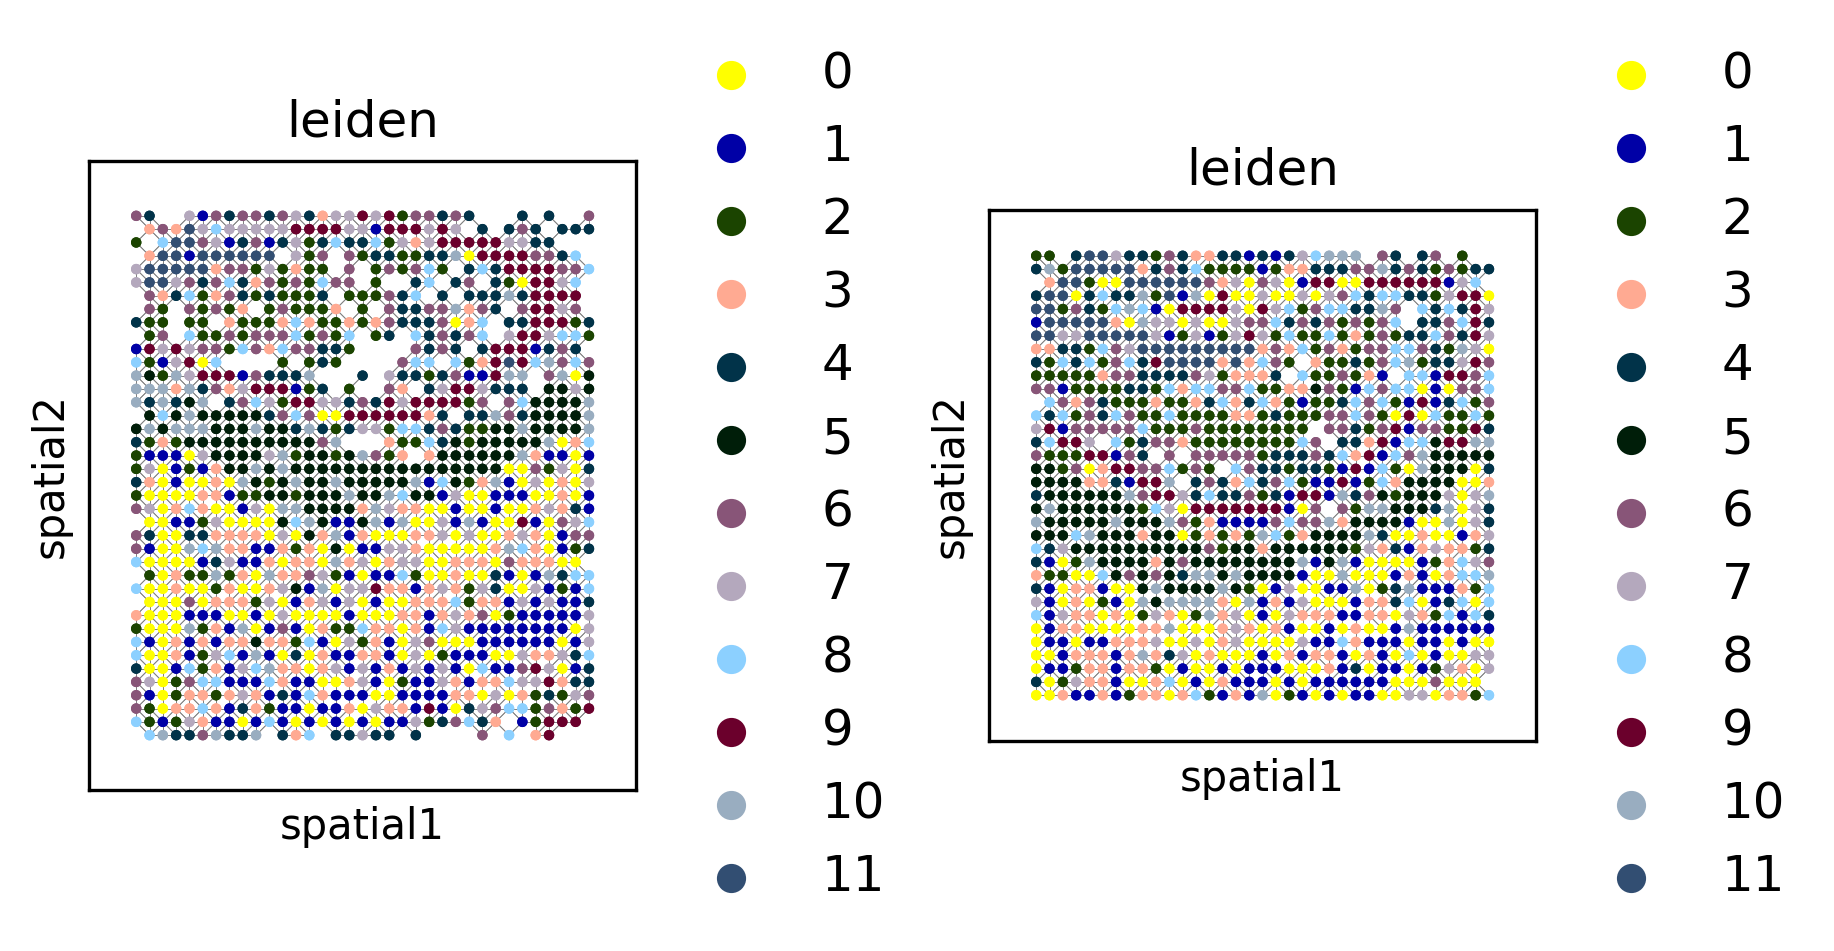

In [48]:
fig, axes = plt.subplots(1, 2, constrained_layout=True, dpi=300)
pl.in_situ(demo, color="leiden", legend_fontsize="large", edgecolors='none', size=25, axes=axes)

### Comparing empirical correlations to learned affinities

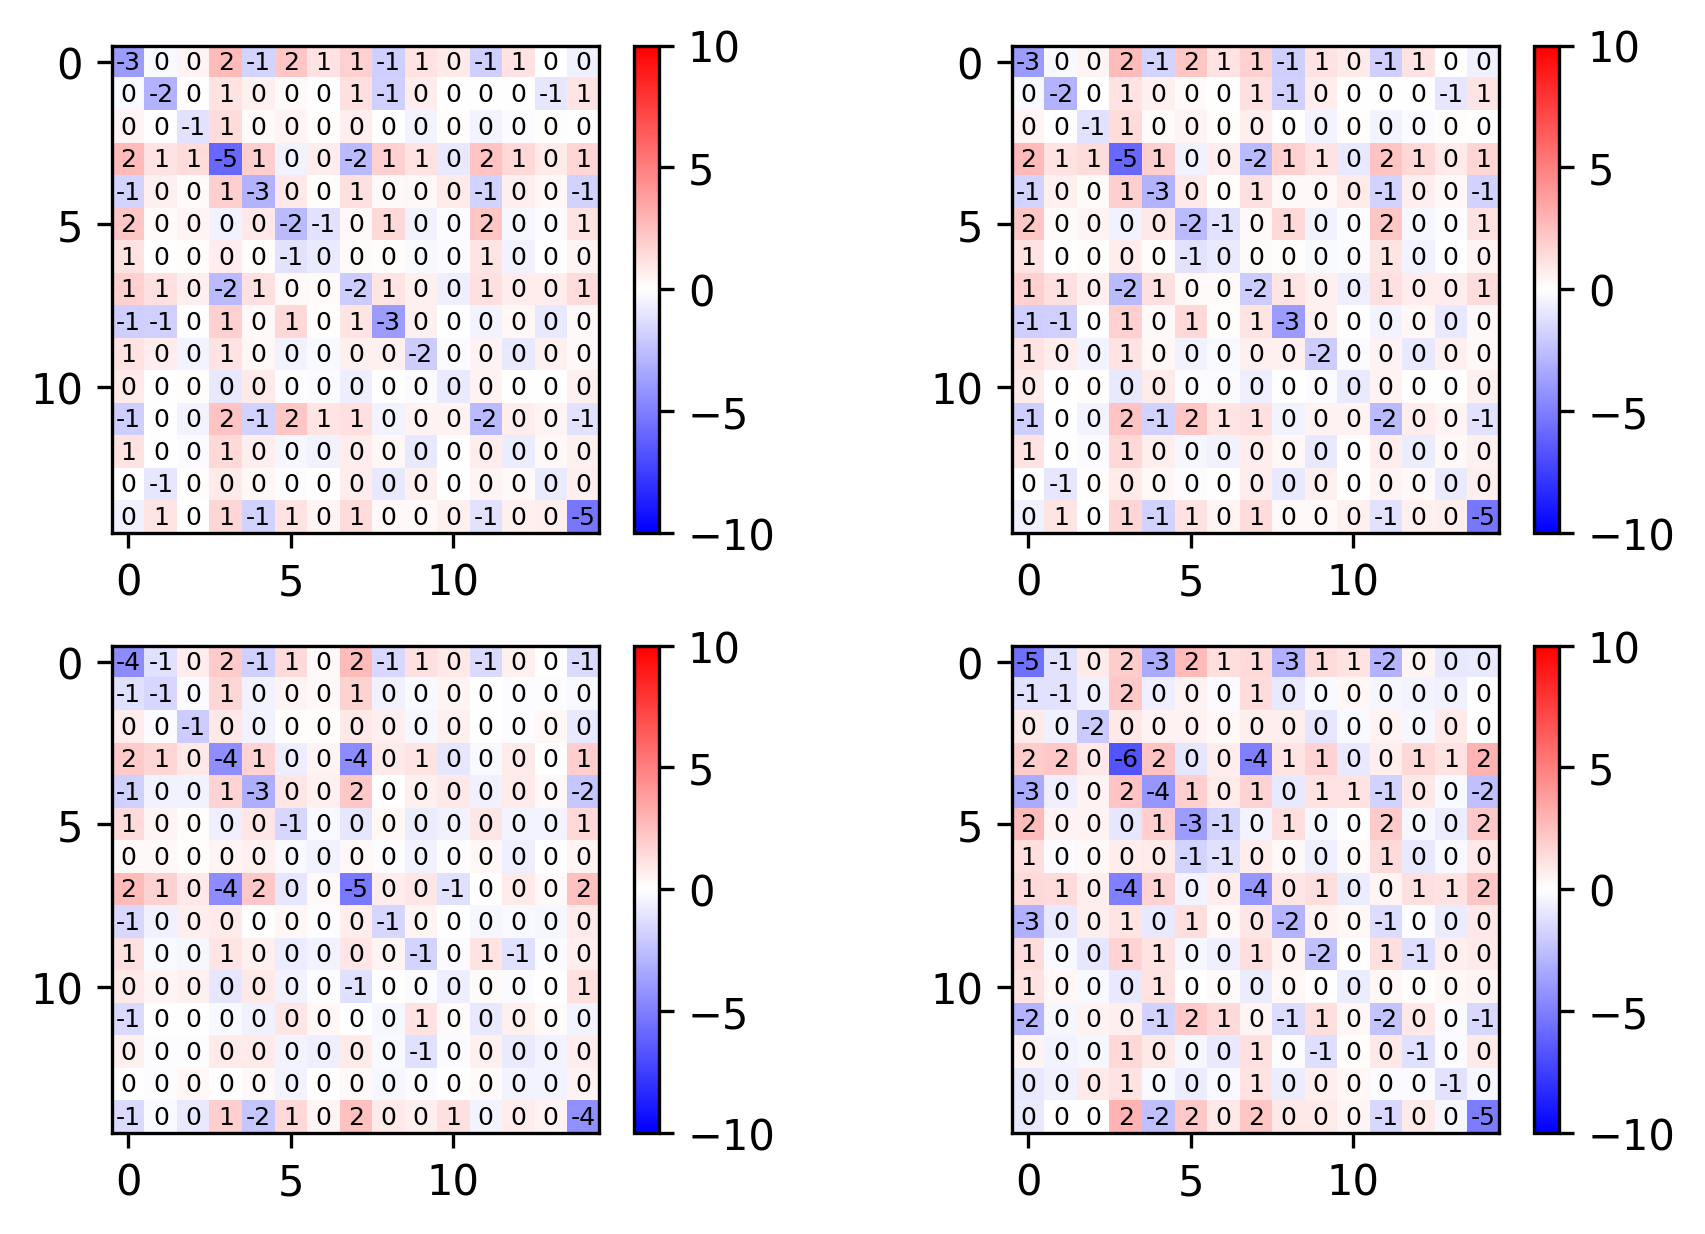

In [28]:
fig, axes = plt.subplots(2, 2, constrained_layout=True, dpi=300)
pl.multireplicate_heatmap(demo, label_values=True, label_font_size=6, uns="Sigma_x_inv", aspect=1, cmap="bwr", vmin=-10, vmax=10, axes=axes[0])
pl.multireplicate_heatmap(demo, label_values=True, label_font_size=6, uns="empirical_correlation", aspect=1, cmap="bwr", vmin=-10, vmax=10, axes=axes[1])

### Plot all metagenes _in-situ_

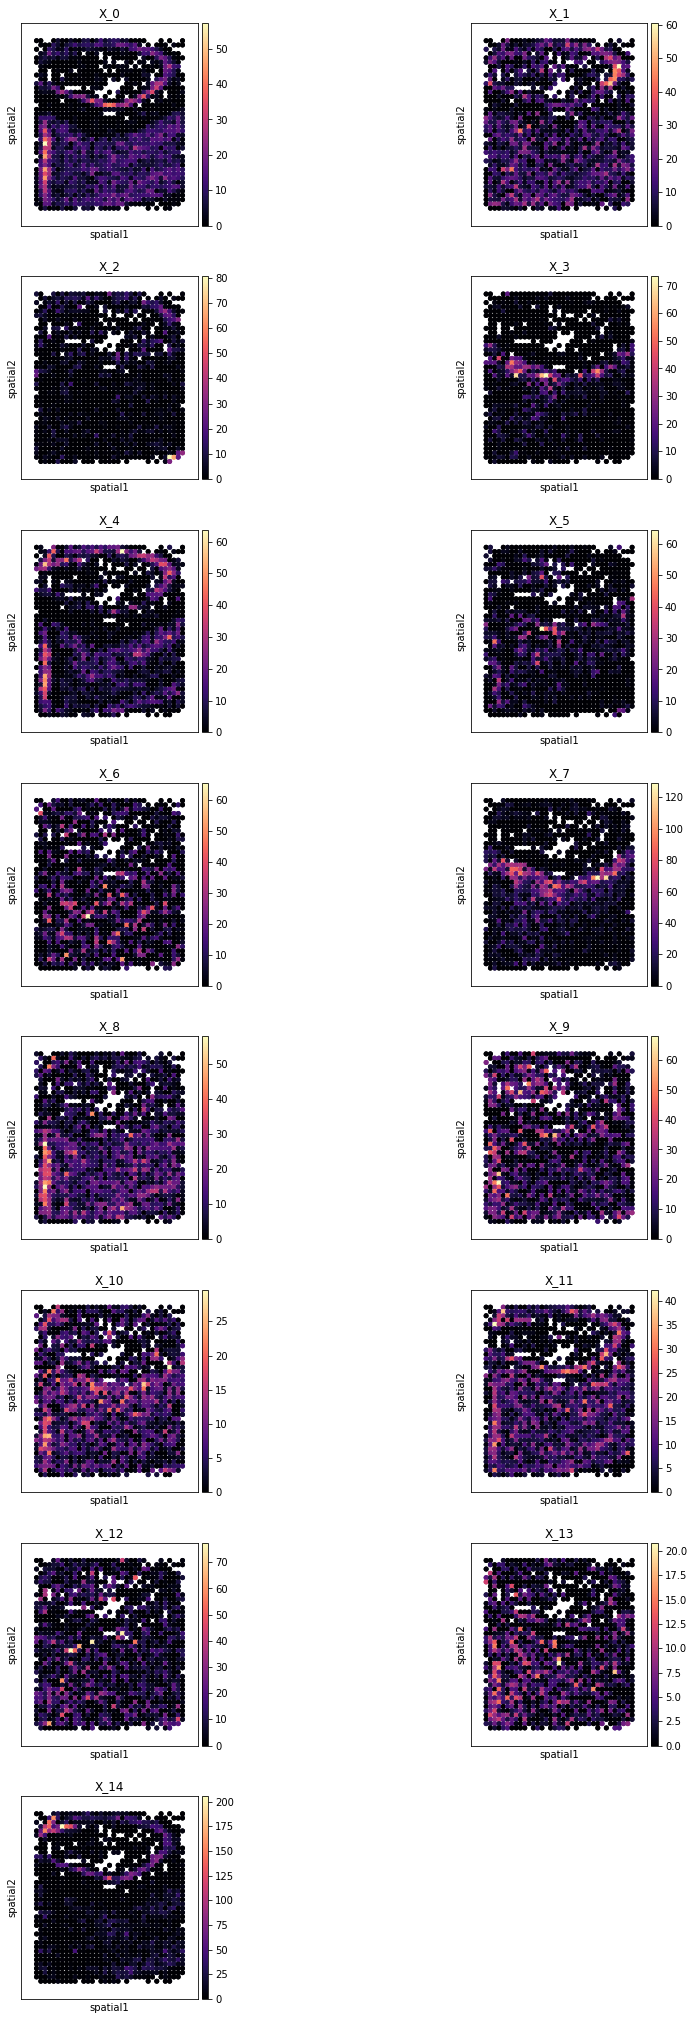

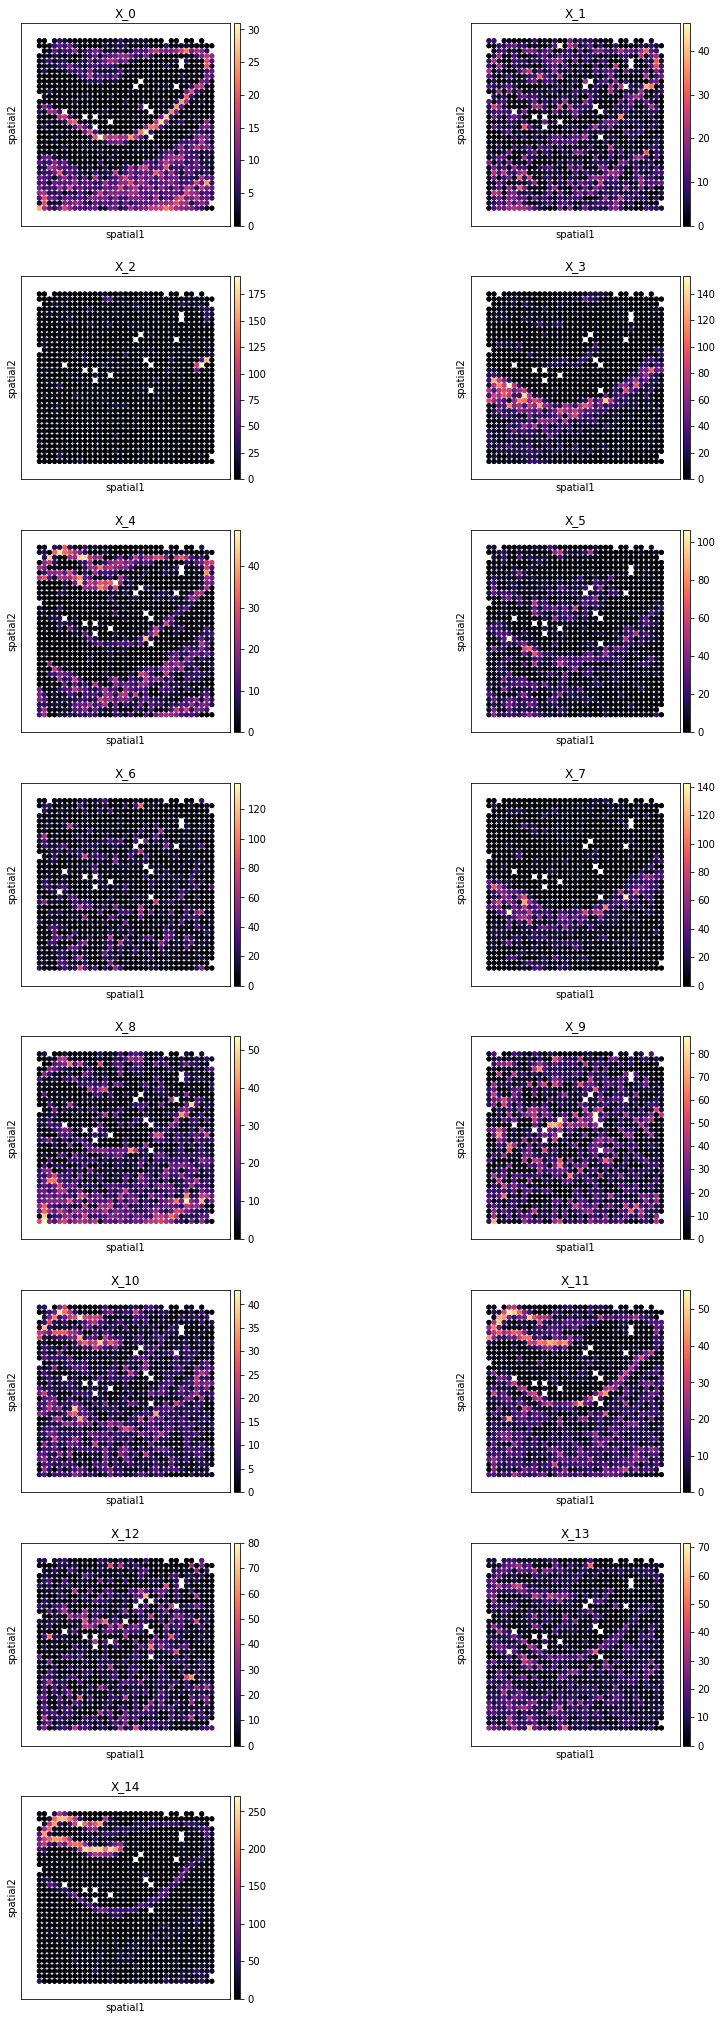

In [50]:
pl.all_embeddings(demo, size=100, edgecolors='none', cmap="magma")

## Hierarchical Analysis

Because we used the hierarchical setting, we can repeat our analyses at higher resolution of the data. This can be accomplished using the `level` parameter. Most of the analysis/plotting functions accept this parameter, and it can be used to indicate which hierarchical analysis the function should be computed at. `level=0` indicates the highest (original) resolution, whereas `level=model.hierarchical_levels - 1` indicates the lowest resolution.

In [32]:
demo.hierarchical_levels

2

In [33]:
# Postprocessing
tl.preprocess_embeddings(demo, level=0, normalized_key="normalized_X")
tl.leiden(demo, joint=True, level=0, use_rep="normalized_X")
tl.compute_empirical_correlations(demo, level=0, feature="X")

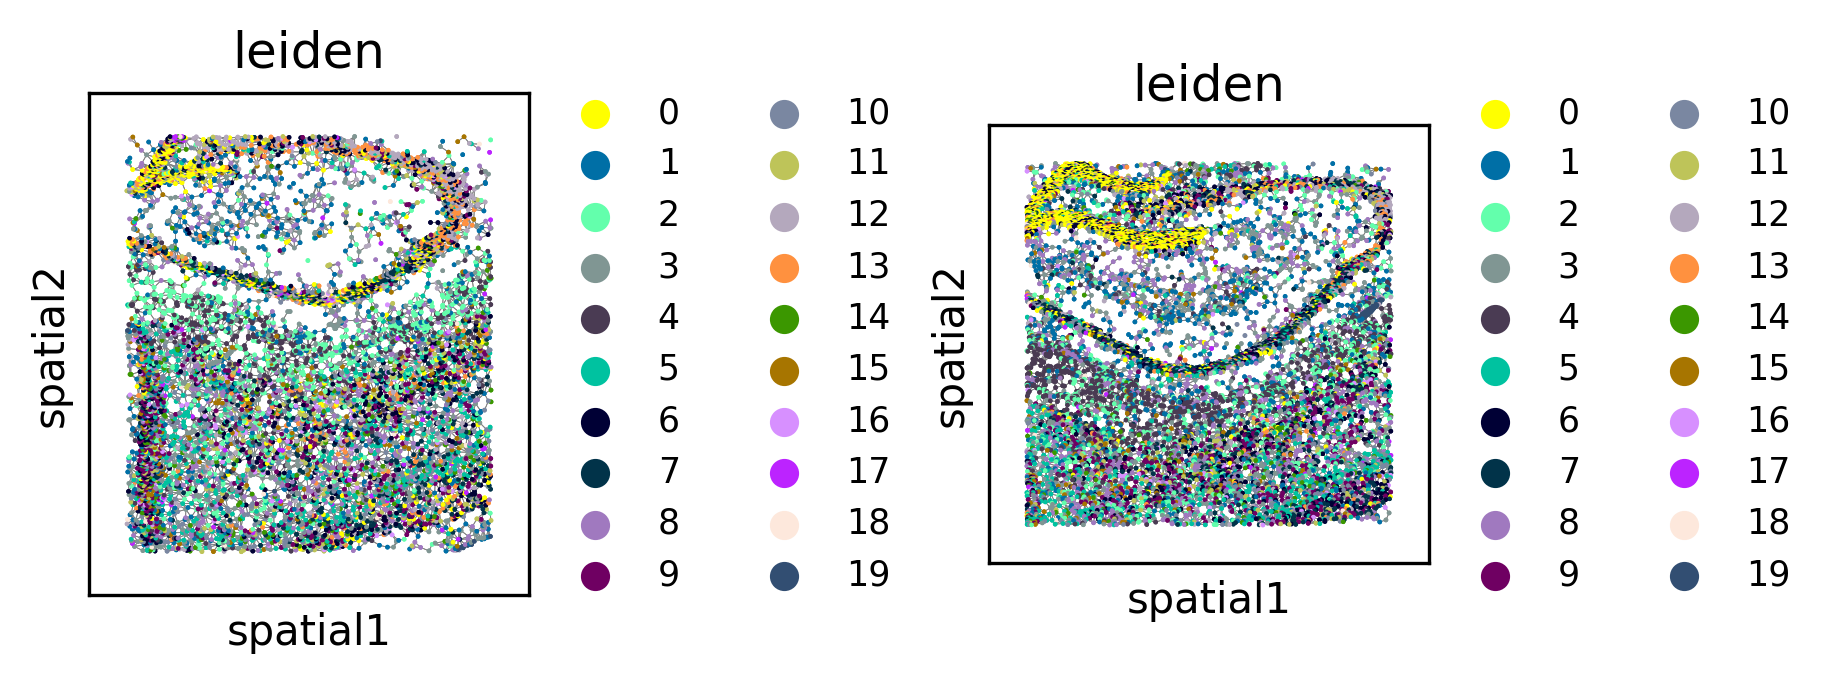

In [46]:
# Plot in-situ high resolution clusters
fig, axes = plt.subplots(1, 2, constrained_layout=True, dpi=300)
pl.in_situ(demo, level=0, color="leiden", legend_fontsize="small", edgecolors='none', size=5, axes=axes)

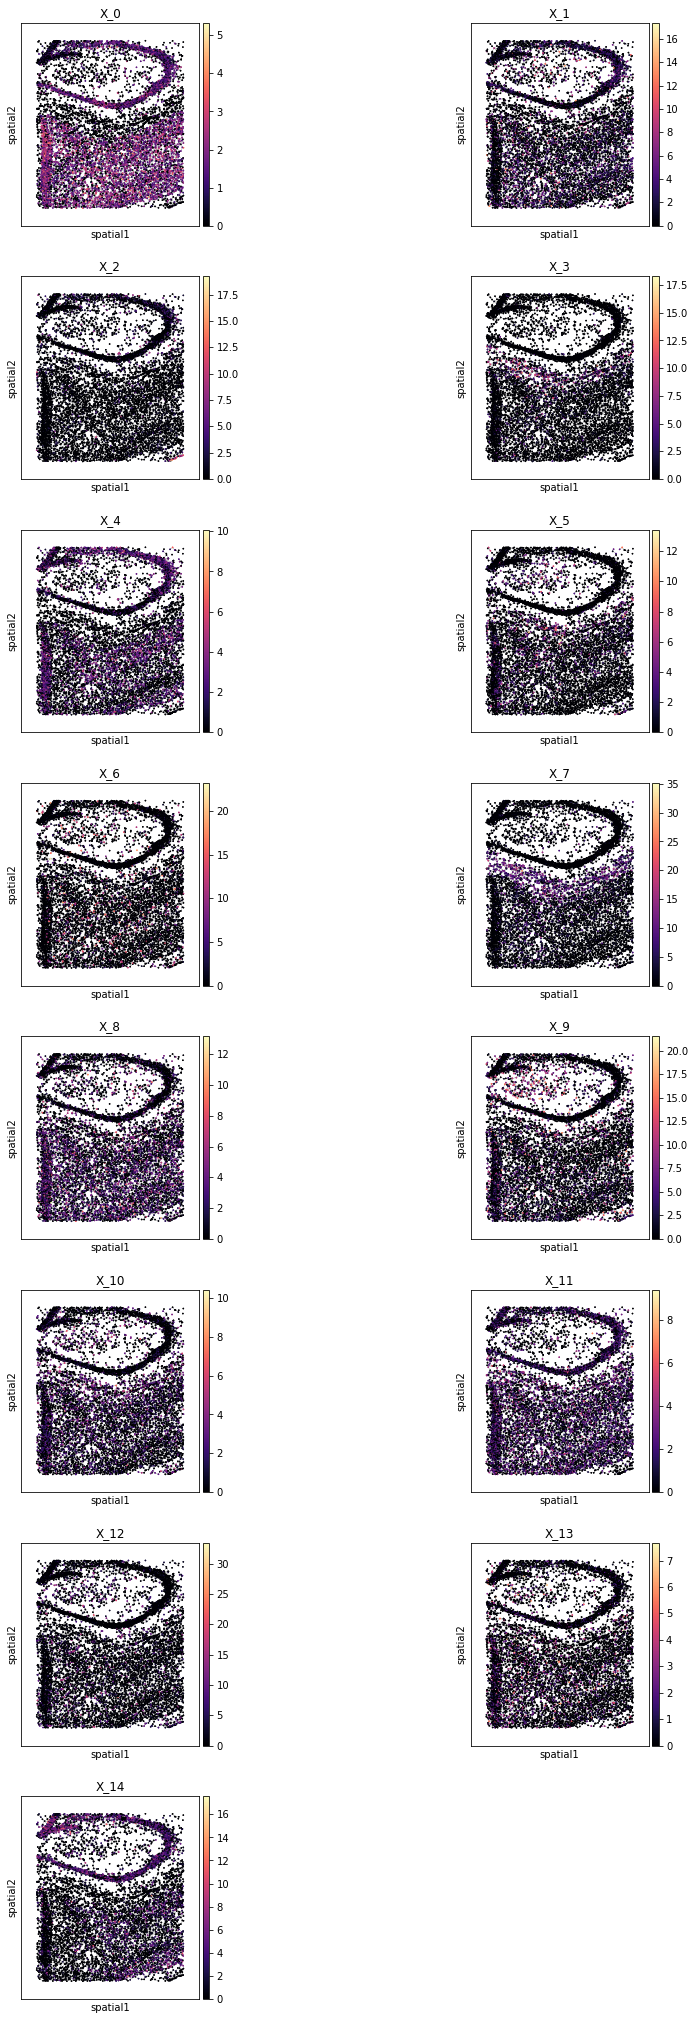

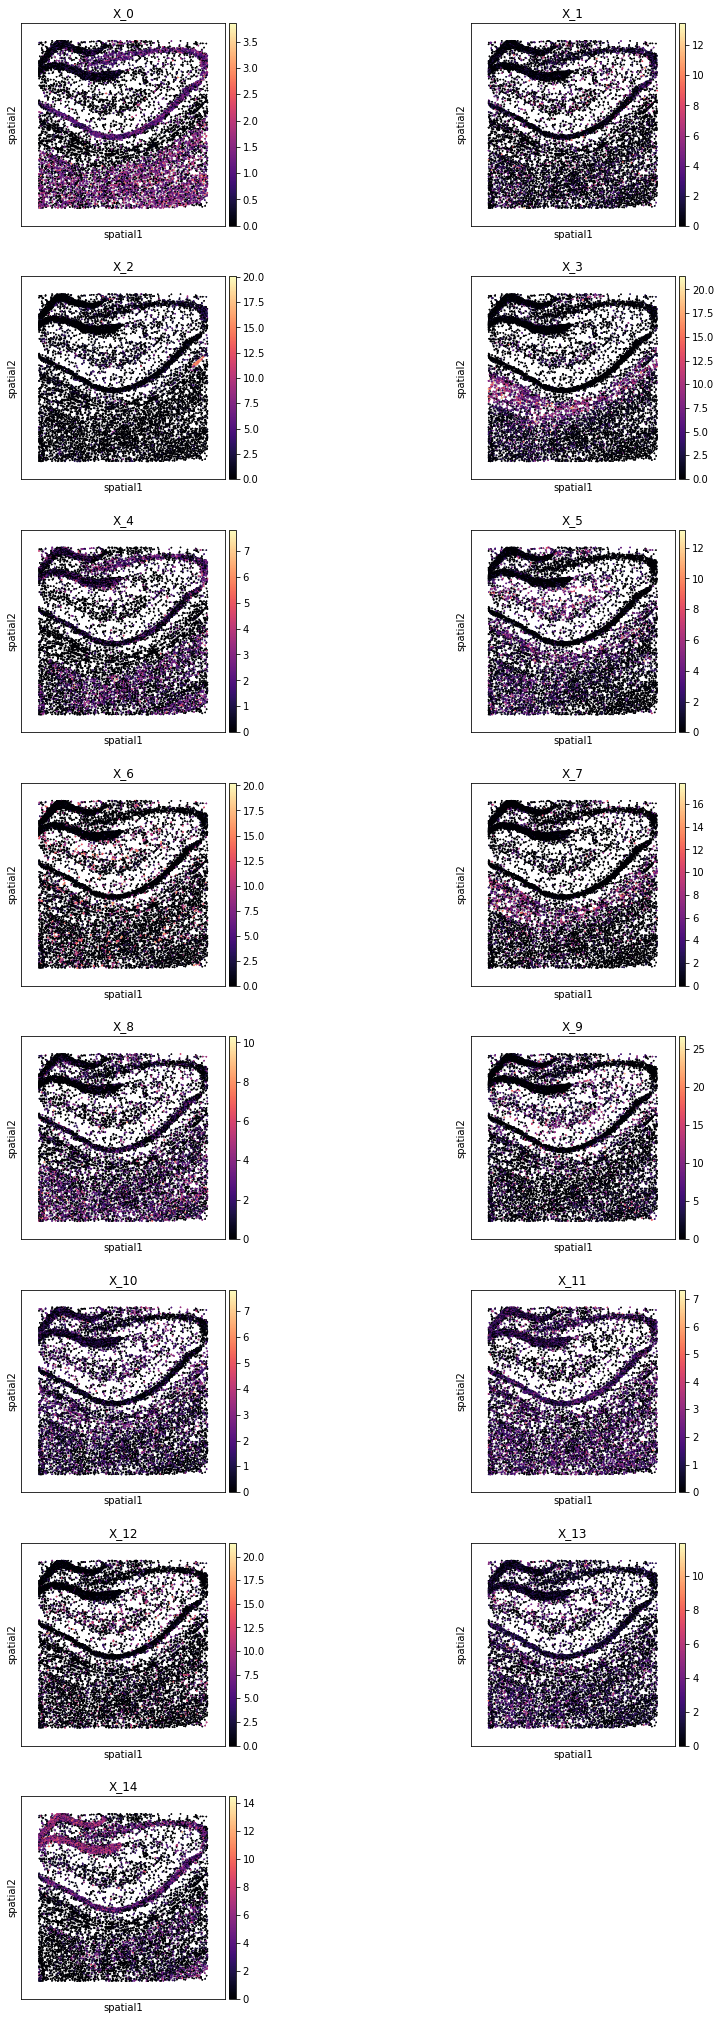

In [53]:
# Plot in-situ high resolution metagene embeddings
pl.all_embeddings(demo, level=0, size=10, edgecolors='none', cmap="magma")

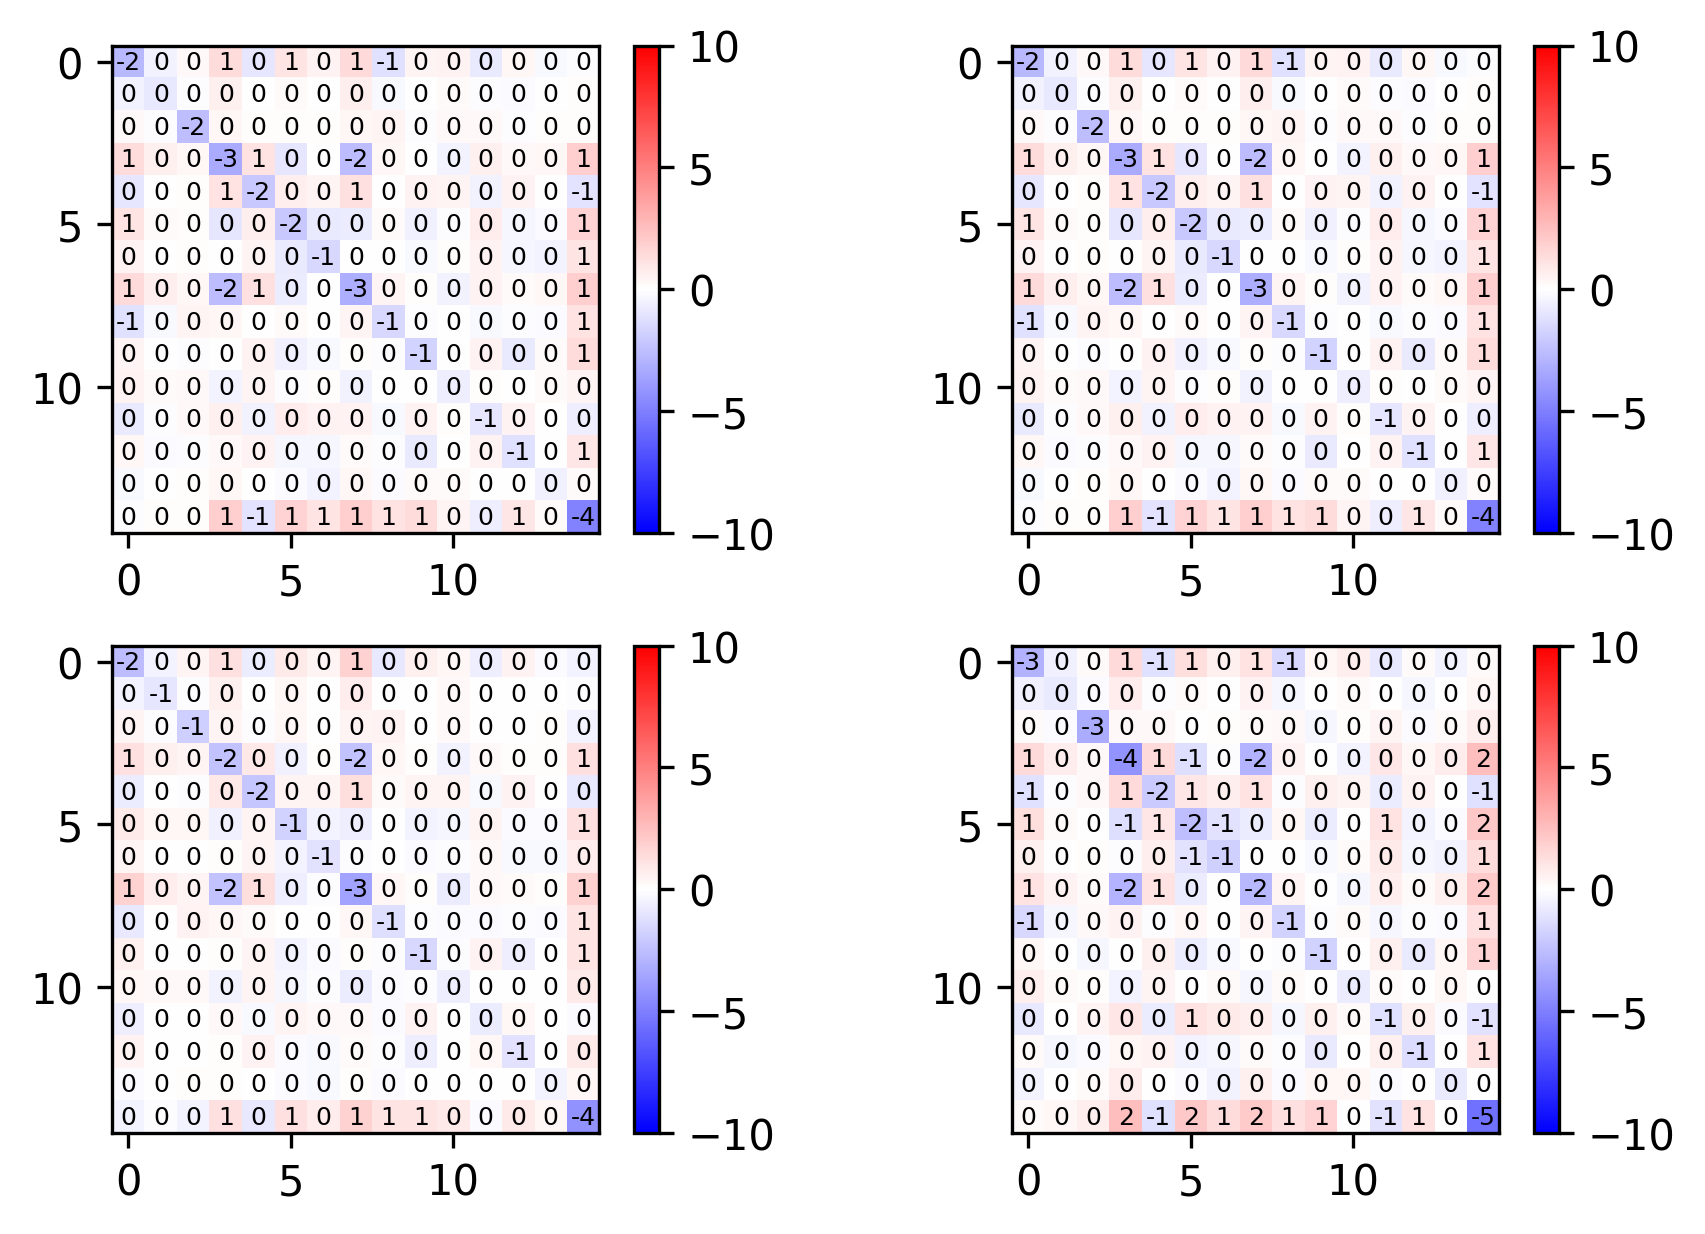

In [54]:
fig, axes = plt.subplots(2, 2, constrained_layout=True, dpi=300)
pl.multireplicate_heatmap(demo, level=0, label_values=True, label_font_size=6, uns="Sigma_x_inv", aspect=1, cmap="bwr", vmin=-10, vmax=10, axes=axes[0])
pl.multireplicate_heatmap(demo, level=0, label_values=True, label_font_size=6, uns="empirical_correlation", aspect=1, cmap="bwr", vmin=-10, vmax=10, axes=axes[1])

### Custom plotting function

You can create your own plotting functions using the `popari._dataset_utils._broadcast_operator` function.

In [11]:
# TODO